In [239]:
from helpers import helper_functions
import time
import os

import tensorflow as tf
import numpy as np
from keras import models
from keras import layers
from keras import optimizers
import matplotlib.pyplot as plt
import yaml

In [240]:
#root_dir='/global/cscratch1/sd/abbatej/autoruns/no_smoothing/numlayers_0_densact_linear_denssize_20'
#root_dir='/global/homes/a/abbatej/plasma_profiles_predictor/test_models'
#root_dir='/global/homes/a/abbatej/plasma_profiles_predictor'
root_dir='/global/cscratch1/sd/abbatej/autoruns/delay_with_0d_lookahead_2/ncomponents_None_delay_3_prelayers_2_size_20_rnnsize_20_'
input_dir='/global/homes/a/abbatej/'
model_filename='model.h5'
#model_filename='gru_cnn_renormed_40.h5'

def load_config(config_file):
    with open(config_file) as f:
        config = yaml.load(f)
    return config
config=load_config(os.path.join(root_dir,'conf.yaml'))['data']

In [8]:
# RUN IF YOU NEED TO UPDATE THE DATA, TIMES, ETC
helper_functions.preprocess_data(dirname=config['input_dir_name'], 
                                    sigs_0d=config['sigs_0d'],
                                    sigs_1d=config['sigs_1d'],
                                    sigs_predict=config['sigs_predict'],
                                    n_components=config['n_components'],
                                    avg_window=config['avg_window'],
                                    lookback=config['lookback'],
                                    delay=config['delay'],
                                    train_frac=config['train_frac'],
                                    val_frac=config['val_frac'],
                                    save_data=True)

Removed 15 shots with empty arrays


In [241]:
rho_points = helper_functions.load_obj(os.path.join(input_dir,'rho_standard'))

In [242]:
#sig_names = ['Target current (A)', 'Injected power (kW)', 'Injected torque (Nm)']#, 'Gas A']
sig_keys_0d = config['sigs_0d']
sig_keys_1d = config['sigs_1d']
#sig_keys = ['curr_target', 'pinj', 'tinj'] #['curr_target', 'pinj', 'tinj']

In [243]:
# matplotlib setup
%matplotlib inline

In [244]:
train_data = np.array(helper_functions.load_obj(input_dir+'train_data'))
train_target = np.array(helper_functions.load_obj(input_dir+'train_target'))
val_data = np.array(helper_functions.load_obj(input_dir+'val_data'))
val_target = np.array(helper_functions.load_obj(input_dir+'val_target'))

In [245]:
shot_indices_dictionary = helper_functions.load_obj(input_dir+'shot_indices')
train_shots = shot_indices_dictionary['train_shot_names']
val_shots = shot_indices_dictionary['val_shot_names']
train_shot_inds = shot_indices_dictionary['train_shot_indices']
val_shot_inds = shot_indices_dictionary['val_shot_indices']
train_time = np.array(helper_functions.load_obj(input_dir+'train_time'))
val_time = np.array(helper_functions.load_obj(input_dir+'val_time'))

In [246]:
means = helper_functions.load_obj(input_dir+'means')
stds = helper_functions.load_obj(input_dir+'stds')

In [247]:
if config['n_components'] is not None:
    pca = helper_functions.load_obj(input_dir+'pca')

In [248]:
loaded_model=models.load_model(os.path.join(root_dir,model_filename))

loaded_model.compile(optimizer=optimizers.RMSprop(lr=.001),
                     metrics=['mae'], loss='mse')

In [249]:
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8, 32)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 8, 20)             660       
_________________________________________________________________
dense_2 (Dense)              (None, 8, 20)             420       
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                630       
Total params: 4,990
Trainable params: 4,990
Non-trainable params: 0
_________________________________________________________________


In [275]:
for layer in loaded_model.layers:
    print(layer)
    for weight in layer.get_weights():
        print(weight.shape)
    print(len(layer.get_weights()))

0
(32, 20)
(20,)
2
(20, 20)
(20,)
2
(20, 80)
(20, 80)
(80,)
3
(20, 30)
(30,)
2


In [284]:
dense1A = loaded_model.layers[1].get_weights()[0]
dense1B = loaded_model.layers[1].get_weights()[1]

dense2A = loaded_model.layers[2].get_weights()[0]
dense2B = loaded_model.layers[2].get_weights()[1]

lstm0 = loaded_model.layers[3].get_weights()[0]
lstm1 = loaded_model.layers[3].get_weights()[1]
lstm2 = loaded_model.layers[3].get_weights()[2]

dense3A = loaded_model.layers[4].get_weights()[0]
dense3B = loaded_model.layers[4].get_weights()[1]

In [287]:
np.savetxt('textfiles/dense1A.txt',dense1A)
np.savetxt('textfiles/dense1B.txt',dense1B)

np.savetxt('textfiles/dense2A.txt',dense2A)
np.savetxt('textfiles/dense2B.txt',dense2B)

np.savetxt('textfiles/lstm0.txt',lstm0)
np.savetxt('textfiles/lstm1.txt',lstm1)
np.savetxt('textfiles/lstm2.txt',lstm2)

np.savetxt('textfiles/dense3A.txt',dense3A)
np.savetxt('textfiles/dense3B.txt',dense3B)

In [283]:
testinputs = np.random.random((8,32))
temp1 = testinputs@dense1A + dense1B
temp2 = temp1@dense2A + dense2B
temp3 = temp2@lstm0@lstm1+lstm2
temp4 = temp3@dense3A + dense3B

ValueError: shapes (8,80) and (20,80) not aligned: 80 (dim 1) != 20 (dim 0)

In [18]:
input_data=val_data
output_data=val_target

In [19]:
# Get ML model performance
val_mae = abs(loaded_model.predict(input_data)-output_data)

# Compared to having signals zeroed out
if len(sig_keys_0d)>0:
    input_data_zeroed=np.copy(input_data)
    input_data_zeroed[:,:,:len(sig_keys_0d)]=0
    val_mae_holdout = abs(loaded_model.predict(input_data_zeroed)-output_data)

In [20]:
avg_val_mae=np.mean(val_mae, axis=0)
std_val_mae=np.std(val_mae, axis=0)
avg_val_mae_holdout=np.mean(val_mae_holdout, axis=0)
std_val_mae_holdout=np.std(val_mae_holdout, axis=0)

In [21]:
# Get performance based on simply guessing the previous timestep
#np.diff(input_data[:,-1,num_sigs:],axis=0)
#baseline_mae=abs(np.diff(input_data[:,-1,num_sigs:],axis=0))
baseline_mae=abs(output_data)

In [22]:
avg_baseline_mae=np.mean(baseline_mae, axis=0)
std_baseline_mae=np.std(baseline_mae, axis=0)

In [23]:
print('{0:.5f}'.format(np.mean(avg_baseline_mae)))
print('{0:.5f}'.format(np.mean(avg_val_mae)))

0.08261
0.07481


In [238]:
print(input_data.shape)

(35460, 9, 4)


In [656]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression

X=train_data[:,-1,:num_sigs]
Y=train_target[:]

reg = LinearRegression().fit(X, Y)

baseline_reg_mae = abs(reg.predict(val_data[:,-1,:num_sigs])-val_target)
avg_baseline_reg_mae = np.mean(baseline_reg_mae, axis=0)

In [657]:
from sklearn.linear_model import LinearRegression

X=train_data[:,-1,:num_sigs]
Y=train_target[:]

reg = LinearRegression().fit(X, Y)

baseline_reg_mae = abs(reg.predict(val_data[:,-1,:num_sigs])-val_target)
avg_baseline_reg_mae = np.mean(baseline_reg_mae, axis=0)

In [24]:
plt.rcParams['figure.figsize'] = [15, 10]
font={'size': 20, 'weight':'heavy'}
plt.rc('font', **font)

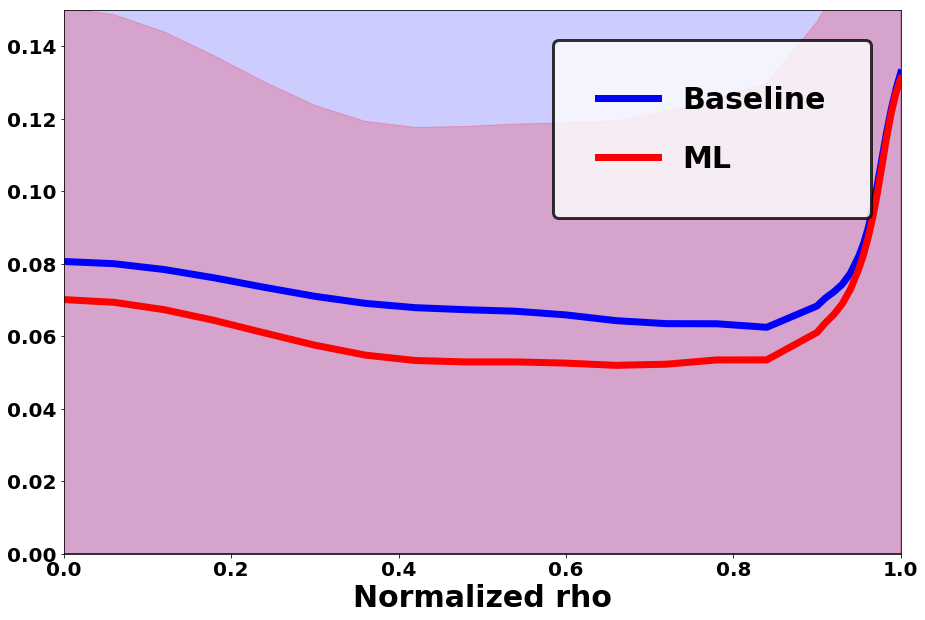

In [25]:
# plt.plot(rho_points,avg_val_mae, c='r', alpha=.5)
# plt.plot(rho_points, avg_baseline_mae, c='b', alpha=.5)
plt.fill_between(rho_points, avg_baseline_mae - std_baseline_mae, avg_baseline_mae + std_baseline_mae, color='b', alpha=0.2)
plt.fill_between(rho_points, avg_val_mae - std_val_mae, avg_val_mae + std_val_mae, color='r', alpha=0.2)

#plt.plot(rho_points, avg_baseline_reg_mae, c='k', label='Baseline Linear Regression', linewidth=7.0)
plt.plot(rho_points, avg_baseline_mae, c='b', label='Baseline', linewidth=7.0)
plt.plot(rho_points,avg_val_mae, c='r', label='ML', linewidth=7.0)
# plt.plot(rho_points,avg_val_mae_holdout, c='b', label='ML no actuators', linewidth=7.0)
# plt.fill_between(rho_points, avg_baseline_mae - std_baseline_mae, avg_baseline_mae + std_baseline_mae, color='b', alpha=0.2)
# plt.fill_between(rho_points, avg_val_mae - std_val_mae, avg_val_mae + std_val_mae, color='r', alpha=0.2)

leg=plt.legend(loc='upper right', edgecolor='k', borderaxespad=1.0, borderpad=1.5, labelspacing=1.0, fontsize=30)
leg.get_frame().set_linewidth(3.0)
#leg.get_frame().set_edgecolor('k')
#plt.title('Comparing prediction error with and without rho=30', fontweight='heavy', fontsize=40)
plt.xlabel('Normalized rho', fontweight='heavy', fontsize=30)
#plt.ylabel('(Model with rho=30) - (Model without rho=30)', fontweight='heavy', fontsize=30)
plt.axhline(0,c='k')
plt.ylim(0,.15)
plt.xlim(0,1.0)
plt.show()

In [50]:
# The following must have already been run: 
# shot_indices_dictionary = helper_functions.load_obj(input_dir+'shot_indices')
# train_shots = shot_indices_dictionary['train_shot_names']
# val_shots = shot_indices_dictionary['val_shot_names']
# train_shot_inds = shot_indices_dictionary['train_shot_indices']
# val_shot_inds = shot_indices_dictionary['val_shot_indices']

def plot_timestep(timestep, train=False, normalized=True, 
                  sig_to_perturb='pinj'):
    
    delay = config['delay']
    titlesize=20
    othersize=20
    legendsize=15
    linewidth=7
    smalllinewidth=3
    
    if(train):
        data=train_data
        target=train_target
        shot_nums=train_shots
        shot_inds=train_shot_inds
        true_times=train_time
    else:
        data=val_data
        target=val_target
        shot_nums=val_shots
        shot_inds=val_shot_inds
        true_times=val_time
        
    index = np.searchsorted(shot_inds, timestep, side='right')-1
    times=list(range(shot_inds[index],shot_inds[index+1]))

    shot_num=shot_nums[index]
    
    input_data=np.array(data)[timestep:timestep+1]
    #input_data[:,:,:3]=0
    
    pred=np.ndarray.flatten(loaded_model.predict(input_data))                      
    
    true=target[timestep]
    # note that timestep 0 will now throw an error 
    prev=target[timestep-1] #data[timestep][-1][num_sigs:]
    
    if normalized:
        pred_real=pred
        true_real=true
        prev_real=prev
    else:
        pred_real = np.multiply(pred,stds['e_temp'])+means['e_temp']
        true_real = np.multiply(true,stds['e_temp'])+means['e_temp']
        prev_real = np.multiply(prev,stds['e_temp'])+means['e_temp']
    
    sigs=data[timestep][-1][:len(sig_keys_0d)] #pinj, tinj, curr
    sigs_all_times=np.array(data)[times,-delay-1,:].T
    
    fig = plt.figure()
    
    baseline_error = abs(true) #abs(true-prev)
    pred_error = abs(true-pred)
    
    ax = fig.add_subplot('222')
    ax.set_title('Electron temperature predictions by the ML model', fontsize=titlesize)
    ax.plot(rho_points,pred_real,label='Predicted', linewidth=smalllinewidth)
    
    
    #### FOR SENSITIVITY ANALYSIS ####
    if sig_to_perturb is not None:
        print('hello')
        if sig_to_perturb in sig_keys_0d:
            sig_index=sig_keys_0d.index(sig_to_perturb)
        else:
            sig_index=range(len(sig_keys_0d),input_data.shape[2])

        input_data_perturbed=input_data.copy()


        # Flatline at the previous value
        input_data_perturbed[:,:,sig_index]=input_data_perturbed[:,0,sig_index]
        # Increase linearly
        #input_data_perturbed[:,:,sig_index]*=[1+i*.1 for i in range(input_data_perturbed.shape[1])]
        # add 10%
        #input_data_perturbed[:,:,sig_index] *= 1.1



        pred_perturbed=np.ndarray.flatten(loaded_model.predict(input_data_perturbed))
        if normalized:
            pred_perturbed_real=pred_perturbed
        else: 
            if config['n_components'] is not None:
                # do the processing with pca, which was already loaded
                pred_perturbed = pca.inverse_transform(pred_perturbed)
            pred_perturbed_real = np.multiply(pred_perturbed,stds['e_temp'])+means['e_temp']
        ax.plot(rho_points,pred_perturbed_real,
                label='Predicted with perturbation to {}'.format(sig_to_perturb), 
                linewidth=smalllinewidth)
    ##################################
    
    
    ax.plot(rho_points,true_real,label='True', linewidth=smalllinewidth)
    #for differences
    ax.axhline(0,label='Baseline',linewidth=smalllinewidth, color='k')
    ### For regular:
    #ax.plot(rho_points,prev_real,label='Previous', linewidth=smalllinewidth)
    
    ax.set_ylabel('Normalized e_temp', fontsize=othersize)
    ax.set_xlim(0,1)
    #ax.set_xlabel('Normalized rho', fontsize=othersize)
    ax.legend(loc='best', fontsize=legendsize)
    
    ax = fig.add_subplot('224')
    ax.set_title('Error in e_temp predictions', fontsize=titlesize)
    ax.plot(rho_points, pred_error, color='red', label='Model error for one example', linewidth=linewidth)
    ax.plot(rho_points, avg_val_mae, color='red', linestyle='--', label='Average prediction error', linewidth=smalllinewidth)
    ax.fill_between(rho_points,avg_val_mae-std_val_mae, avg_val_mae+std_val_mae, color='red', alpha=.2)
    ax.axhline(0,color='k')
    ax.plot(rho_points, baseline_error, color='b', label='Baseline error for one example', linewidth=linewidth)
    ax.plot(rho_points, avg_baseline_mae, color='b', linestyle='--', label='Average baseline error', linewidth=smalllinewidth)
    ax.fill_between(rho_points,avg_baseline_mae-std_baseline_mae, avg_baseline_mae+std_baseline_mae, color='blue', alpha=.2)
    ax.set_ylim(0,.25)
    ax.set_xlim(0,1)
    ax.legend(loc='upper left', fontsize=legendsize)
    ax.set_ylabel('Error (abs val)', fontsize=othersize)
    ax.set_xlabel('Normalized rho', fontsize=othersize)
        
        #textstr='Baseline error: %.2f \nModel error: %.3f'%(np.mean(baseline_error),np.mean(pred_error))
        #ax.text(0.05,0.1,textstr, transform=ax.transAxes)
    
    #plt.subplots_adjust(hspace=.5)

    for i in range(len(sig_keys_0d)):
        which_plot='{}2{}'.format(len(sig_keys_0d)+len(sig_keys_1d),2*i+1) 
        ax=fig.add_subplot(which_plot) #axes[i+1]
        #ax.plot(times,sigs_all_times[i])
        if normalized:
            ax.plot(true_times[times],sigs_all_times[i])
            if sig_to_perturb is not None:
                if (i==sig_index):
                    ax.plot(true_times[timestep-config['lookback']:timestep+config['delay']+1],
                        input_data_perturbed[0,:,i],
                        linewidth=10)
        else:
            normalized_sig=(sigs_all_times[i]*stds[sig_keys_0d[i]])+means[sig_keys_0d[i]]
            ax.plot(true_times[times],normalized_sig)
        ax.set_ylabel(sig_keys_0d[i], fontsize=titlesize)
        ax.axvline(true_times[timestep],color='r')
        ax.axvline(true_times[timestep+delay],color='b')
            
    for i in range(len(sig_keys_1d)):
        which_plot='{}2{}'.format(len(sig_keys_0d)+len(sig_keys_1d),2*(len(sig_keys_0d)+i)+1) 
        ax=fig.add_subplot(which_plot) #axes[i+1]
        #ax.plot(times,sigs_all_times[i])
        rho_len_in = int((data.shape[2]-len(sig_keys_0d))/len(sig_keys_1d))
        if normalized:
            sig_trace_1d = np.mean(sigs_all_times[len(sig_keys_0d)+i*rho_len_in:len(sig_keys_0d)+(i+1)*rho_len_in],axis=0)
            ax.plot(true_times[times],sig_trace_1d)
        else:
            tmp = sigs_all_times[len(sig_keys_0d)+i*rho_len_in:len(sig_keys_0d)+(i+1)*rho_len_in]
            if config['n_components'] is not None:
                # do the processing with pca, which was already loaded
                tmp = pca.inverse_transform(tmp)
            # convert back by multiplying by std, adding mean
            sig_trace_1d = (stds[sig_keys_1d[i]].dot(tmp)+sum(means[sig_keys_1d[i]]))/rho_len_in
            ax.plot(true_times[times],sig_trace_1d)
        ax.set_ylabel('mean {}'.format(sig_keys_1d[i]), fontsize=titlesize)
        ax.axvline(true_times[timestep],color='r')
        ax.axvline(true_times[timestep+delay],color='b')
        if i==len(sig_keys_0d)+len(sig_keys_1d)-1:
            ax.set_xlabel('Time (ms)', fontsize=othersize)
    
    fig.suptitle('Shot {} (timestep {})'.format(shot_num,timestep))
    plt.show()

In [27]:
plt.rcParams['figure.figsize'] = [20, 15]
font={'size': 20, 'weight': 'heavy'}
plt.rc('font', **font)

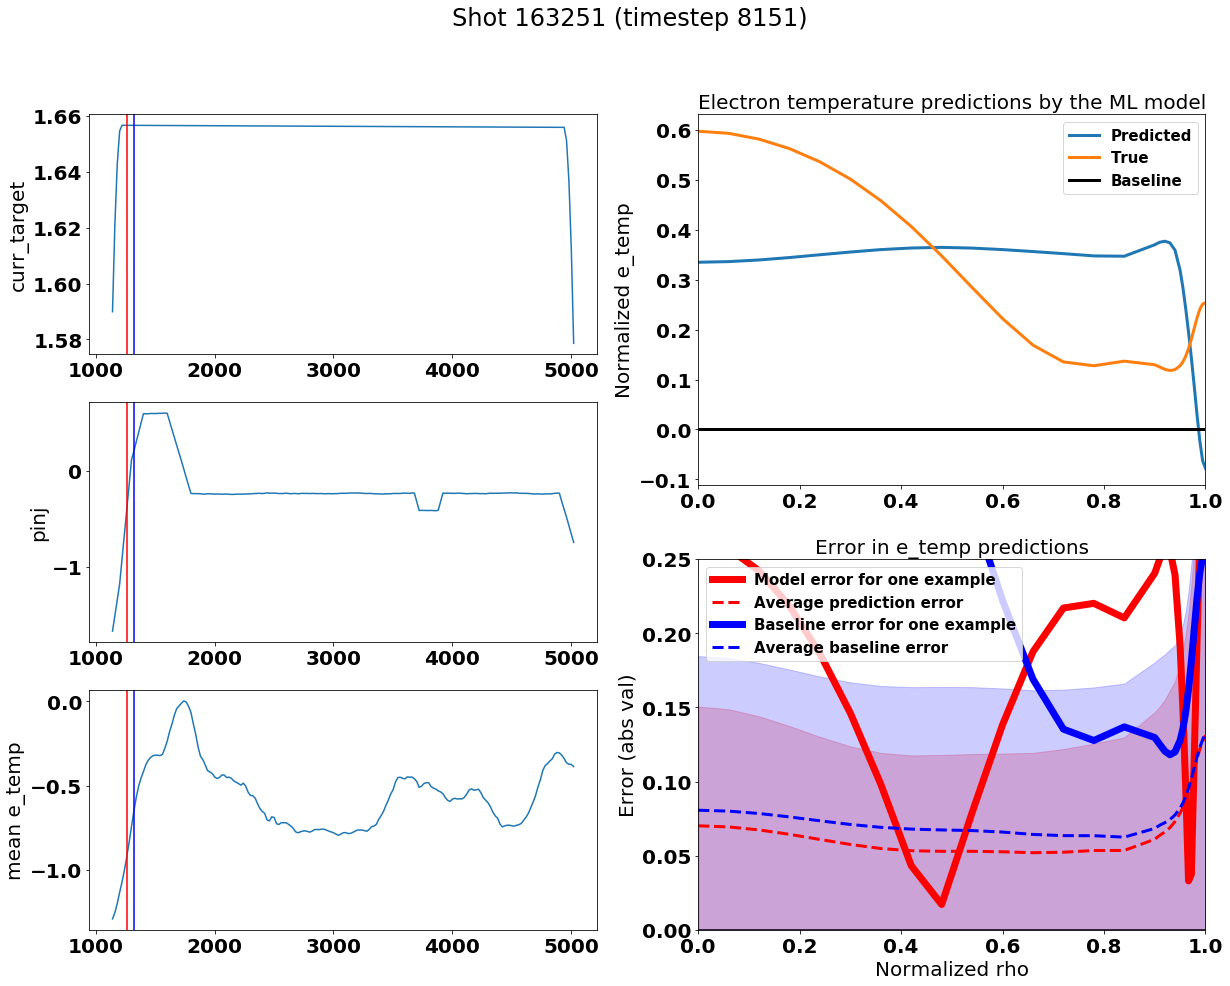

In [238]:
import random
random.randint(0,len(val_data))
timestep=np.random.choice(val_shot_inds)+np.random.randint(10)

#random.randint(0,len(train_data))
#timestep=np.random.choice(train_shot_inds)+np.random.randint(10)

#i+=2
#timestep=val_shot_inds[val_shots.index(163174)]+i

#timestep=val_shot_inds[42]+20
plot_timestep(timestep, train=False, normalized=True, sig_to_perturb=None)

In [30]:
def plot_timestep_creative(timestep, train=False, normalized=True, 
                  perturbations=[], sig_to_perturb='pinj'):
    
    delay = config['delay']
    titlesize=20
    othersize=20
    legendsize=15
    linewidth=7
    smalllinewidth=3
    
    if(train):
        data=train_data
        target=train_target
        shot_nums=train_shots
        shot_inds=train_shot_inds
        true_times=train_time
    else:
        data=val_data
        target=val_target
        shot_nums=val_shots
        shot_inds=val_shot_inds
        true_times=val_time
        
    index = np.searchsorted(shot_inds, timestep, side='right')-1
    times=list(range(shot_inds[index],shot_inds[index+1]))

    shot_num=shot_nums[index]
    
    input_data=np.array(data)[timestep:timestep+1]
    #input_data[:,:,:3]=0
    
    pred=np.ndarray.flatten(loaded_model.predict(input_data))                      
    
    true=target[timestep]
    # note that timestep 0 will now throw an error 
    prev=target[timestep-1] #data[timestep][-1][num_sigs:]
    
    if normalized:
        pred_real=pred
        true_real=true
        prev_real=prev
    else:
        pred_real = np.multiply(pred,stds['e_temp'])+means['e_temp']
        true_real = np.multiply(true,stds['e_temp'])+means['e_temp']
        prev_real = np.multiply(prev,stds['e_temp'])+means['e_temp']
    
    sigs=data[timestep][-1][:len(sig_keys_0d)] #pinj, tinj, curr
    sigs_all_times=np.array(data)[times,-delay-1,:].T
    
    fig = plt.figure()
    
    baseline_error = abs(true) #abs(true-prev)
    pred_error = abs(true-pred)
    
    ax = fig.add_subplot('222')
    ax.set_title('Electron temperature predictions by the ML model', fontsize=titlesize)
    ax.plot(rho_points,pred_real,label='Predicted', linewidth=smalllinewidth)
    
    
    #### FOR SENSITIVITY ANALYSIS ####
    if len(perturbations)>0:
        if sig_to_perturb in sig_keys_0d:
            sig_index=sig_keys_0d.index(sig_to_perturb)
        else:
            sig_index=range(len(sig_keys_0d),input_data.shape[2])
        for perturbation in perturbations:
            input_data_no_actuators=input_data.copy()
            input_data_no_actuators[:,:,sig_index]+=perturbation
            pred_no_actuators=np.ndarray.flatten(loaded_model.predict(input_data_no_actuators))

            if normalized:
                pred_no_actuators_real=pred_no_actuators
            else: 
                pred_no_actuators_real = np.multiply(pred_no_actuators,stds['e_temp'])+means['e_temp']

            ax.plot(rho_points,pred_no_actuators_real,
                    label='Predicted with {} additional std to {}'.format(perturbation, sig_to_perturb), 
                    linewidth=smalllinewidth)
    ##################################
    
    
    ax.plot(rho_points,true_real,label='True', linewidth=smalllinewidth)
    #for differences
    ax.axhline(0,label='Baseline',linewidth=smalllinewidth, color='k')
    ### For regular:
    #ax.plot(rho_points,prev_real,label='Previous', linewidth=smalllinewidth)
    
    ax.set_ylabel('Normalized e_temp', fontsize=othersize)
    ax.set_xlim(0,1)
    #ax.set_xlabel('Normalized rho', fontsize=othersize)
    ax.legend(loc='best', fontsize=legendsize)
    
    ax = fig.add_subplot('224')
    ax.set_title('Error in e_temp predictions', fontsize=titlesize)
    ax.plot(rho_points, pred_error, color='red', label='Model error for one example', linewidth=linewidth)
    ax.plot(rho_points, avg_val_mae, color='red', linestyle='--', label='Average prediction error', linewidth=smalllinewidth)
    ax.fill_between(rho_points,avg_val_mae-std_val_mae, avg_val_mae+std_val_mae, color='red', alpha=.2)
    ax.axhline(0,color='k')
    ax.plot(rho_points, baseline_error, color='b', label='Baseline error for one example', linewidth=linewidth)
    ax.plot(rho_points, avg_baseline_mae, color='b', linestyle='--', label='Average baseline error', linewidth=smalllinewidth)
    ax.fill_between(rho_points,avg_baseline_mae-std_baseline_mae, avg_baseline_mae+std_baseline_mae, color='blue', alpha=.2)
    ax.set_ylim(0,.25)
    ax.set_xlim(0,1)
    ax.legend(loc='upper left', fontsize=legendsize)
    ax.set_ylabel('Error (abs val)', fontsize=othersize)
    ax.set_xlabel('Normalized rho', fontsize=othersize)
        
        #textstr='Baseline error: %.2f \nModel error: %.3f'%(np.mean(baseline_error),np.mean(pred_error))
        #ax.text(0.05,0.1,textstr, transform=ax.transAxes)
    
    #plt.subplots_adjust(hspace=.5)

    for i in range(len(sig_keys_0d)):
        which_plot='{}2{}'.format(len(sig_keys_0d)+len(sig_keys_1d),2*i+1) 
        ax=fig.add_subplot(which_plot) #axes[i+1]
        #ax.plot(times,sigs_all_times[i])
        if normalized:
            ax.plot(true_times[times],sigs_all_times[i])
        else:
            normalized_sig=(sigs_all_times[i]*stds[sig_keys_0d[i]])+means[sig_keys_0d[i]]
            ax.plot(true_times[times],normalized_sig)
        ax.set_ylabel(sig_keys_0d[i], fontsize=titlesize)
        ax.axvline(true_times[timestep],color='r')
        ax.axvline(true_times[timestep+delay],color='b')
            
    for i in range(len(sig_keys_1d)):
        which_plot='{}2{}'.format(len(sig_keys_0d)+len(sig_keys_1d),2*(len(sig_keys_0d)+i)+1) 
        ax=fig.add_subplot(which_plot) #axes[i+1]
        #ax.plot(times,sigs_all_times[i])
        rho_len_in = int((data.shape[2]-len(sig_keys_0d))/len(sig_keys_1d))
        if normalized:
            sig_trace_1d = np.mean(sigs_all_times[len(sig_keys_0d)+i*rho_len_in:len(sig_keys_0d)+(i+1)*rho_len_in],axis=0)
            ax.plot(true_times[times],sig_trace_1d)
        else:
            if config['n_components'] is not None:
                # do the processing with pca, which was already loaded
                pass
            print(sigs_all_times.shape)
            tmp = sigs_all_times[len(sig_keys_0d)+i*rho_len_in:len(sig_keys_0d)+(i+1)*rho_len_in]
            # convert back by multiplying by std, adding mean
            sig_trace_1d = (stds[sig_keys_1d[i]].dot(tmp)+sum(means[sig_keys_1d[i]]))/rho_len_in
            ax.plot(true_times[times],sig_trace_1d)
        ax.set_ylabel('mean {}'.format(sig_keys_1d[i]), fontsize=titlesize)
        ax.axvline(true_times[timestep],color='r')
        ax.axvline(true_times[timestep+delay],color='b')
        if i==len(sig_keys_0d)+len(sig_keys_1d)-1:
            ax.set_xlabel('Time (ms)', fontsize=othersize)
    
    fig.suptitle('Shot {} (timestep {})'.format(shot_num,timestep))
    plt.show()

In [945]:
def plot_presentation_ready(timestep, train=False, normalized=True, 
                  perturbations=[], sig_to_perturb='pinj'):
    
    titlesize=40
    othersize=40
    legendsize=30
    linewidth=12
    smalllinewidth=7
    
    if(train):
        data=train_data
        target=train_target
        shot_nums=train_shots
        shot_inds=train_shot_inds
        true_times=train_time
    else:
        data=val_data
        target=val_target
        shot_nums=val_shots
        shot_inds=val_shot_inds
        true_times=val_time
        
    index = np.searchsorted(shot_inds, timestep, side='right')-1
    times=list(range(shot_inds[index],shot_inds[index+1]))

    shot_num=shot_nums[index]
    
    input_data=np.array(data)[timestep:timestep+1]
    
    pred=np.ndarray.flatten(loaded_model.predict(input_data))                      
    
    true=data[timestep+2,-1,num_sigs:]
    prev=data[timestep+1,-1,num_sigs:]
    pred+=data[timestep+1,-1,num_sigs:]
    
    #prev=target_data[timestep,-1,num_sigs:]
    # note that timestep 0 will now throw an error 
    #prev=target[timestep] #data[timestep][-1][num_sigs:]
    
    if normalized:
        pred_real=pred
        true_real=true
        prev_real=prev
    else:
        pred_real = np.multiply(pred,stds['e_temp'])+means['e_temp']
        true_real = np.multiply(true,stds['e_temp'])+means['e_temp']
        prev_real = np.multiply(prev,stds['e_temp'])+means['e_temp']
    
    fig = plt.figure()
    
    plt.title('Electron temperature profile prediction', fontsize=titlesize)
    plt.plot(rho_points,pred_real,label='ML Prediction at t+1', linewidth=smalllinewidth,c='r')
    
    plt.plot(rho_points,true_real,label='Profile at t+1', linewidth=linewidth,c='b',linestyle=':')
    #for differences
    plt.plot(rho_points, prev_real,label='Profile at t',linewidth=smalllinewidth, color='k')
    ### For regular:
    #ax.plot(rho_points,prev_real,label='Previous', linewidth=smalllinewidth)
    
    plt.ylabel('Electron temperature (keV)', fontsize=othersize)
    plt.xlabel('Spatial position (normalized)', fontsize=othersize)
    plt.xlim(0,1)
    #ax.set_xlabel('Normalized rho', fontsize=othersize)
    plt.legend(loc='best', fontsize=legendsize)
    
    plt.show()

7146


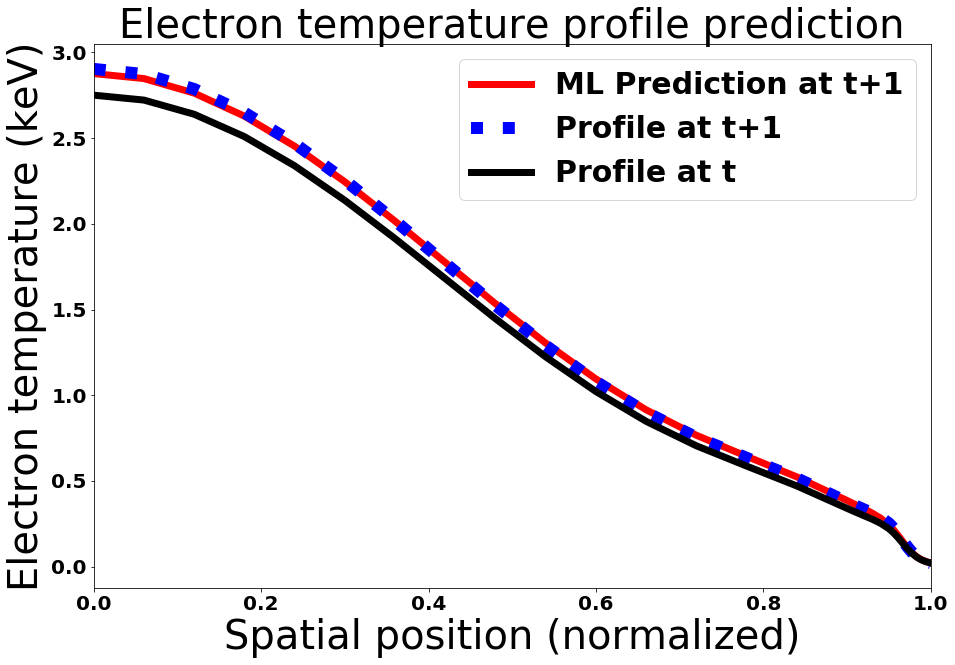

In [950]:
import random
random.randint(0,len(val_data))
timestep=np.random.choice(val_shot_inds)+np.random.randint(10)

#random.randint(0,len(train_data))
#timestep=np.random.choice(train_shot_inds)+np.random.randint(10)

#i+=2
#timestep=val_shot_inds[val_shots.index(163174)]+i

timestep=7146
print(timestep)
plot_presentation_ready(timestep, train=False, normalized=False, perturbations=[-1,1], sig_to_perturb='pinj')